# How a  non-linear inversion should work

In [1]:
%matplotlib inline
from __future__ import print_function, division
from future.builtins import super, range
import numpy as np
import matplotlib.pyplot as plt
from fatiando import utils, mesher
from fatiando.vis import mpl
from fatiando.gravmag import talwani
import cPickle as pickle
from inversion import NonLinearMisfit
#from inversion Smoothness1D

In [2]:
# Make some synthetic data to test the inversion
# The model will be a polygon.
# Reverse x because vertices must be clockwise.
xs = np.linspace(0, 100000, 100)[::-1]
depths = (-1e-15*(xs - 50000)**4 + 8000 -
          3000*np.exp(-(xs - 70000)**2/(10000**2)))
depths -= depths.min()  # Reduce depths to zero
props = {'density': -300}
model = mesher.Polygon(np.transpose([xs, depths]), props)
x = np.linspace(0, 100000, 100)
z = -100*np.ones_like(x)
data = talwani.gz(x, z, [model])
#data = utils.contaminate(talwani.gz(x, z, [model]), 0.5, seed=0)


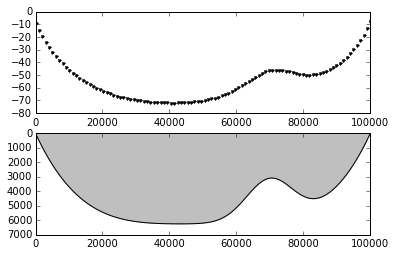

In [3]:
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(x, data, '.k')
ax = plt.subplot(2, 1, 2)
mpl.polygon(model, fill='gray', alpha=0.5)
ax.invert_yaxis()

In [6]:
class PolygonalBasinGravity(NonLinearMisfit):
    def __init__(self, xlim, npoints, props, top=0):
        super().__init__(nparams=npoints, 
                         config=dict(method='newton', 
                                     initial=np.ones(npoints)*3e3))
        self.xlim = xlim
        self.props = props
        self.top = np.zeros(npoints) + top
        tmp = np.linspace(xlim[0], xlim[1], npoints)
        self._xm = np.concatenate([tmp, tmp[::-1]])
        
    def _p2verts(self, p):
        verts = np.empty((self.nparams*2, 2))
        verts[:, 0] = self._xm
        verts[:, 1] = np.concatenate([self.top, p])
        return verts
        
    def predict(self, x, z, p=None):
        if p is None:
            p = self.p_
        verts = self._p2verts(p)
        poly = mesher.Polygon(verts, props=self.props)
        return talwani.gz(x, z, [poly])
    
    def jacobian(self, x, z, p):
        verts = self._p2verts(p)
        delta = np.array([0, 1])
        A = np.empty((x.size, self.nparams))
        for i in range(self.nparams, self.nparams*2 - 1):
            diff_verts = [verts[i + 1], verts[i] - delta,
                          verts[i - 1], verts[i] + delta]
            diff = mesher.Polygon(diff_verts, self.props)
            A[:, i - self.nparams] = talwani.gz(x, z, [diff])/(2*delta[1])
        return A
        
    def fit(self, x, z, gz, weights=None):
        self.optimize(data=gz, x=x, z=z, weights=weights)
        return self      
    
    def fmt_estimate(self, p):
        return mesher.Polygon(self._p2verts(p), props=self.props)

In [7]:
xlim = [x.min(), x.max()]
inv = PolygonalBasinGravity(xlim, npoints=10, props=model.props, top=0)
inv.fit(x, z, data).p_

LinAlgError: Singular matrix

In [ ]:
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(x, data, 'ok')
plt.plot(x, inv.predict(x, z), '-r')
ax = plt.subplot(2, 1, 2)
mpl.polygon(model, fill='gray', alpha=0.5)
mpl.polygon(inv.estimate_, style='o-r')
ax.invert_yaxis()

In [ ]:
plt.hist(inv.residuals(data, x, z), 15)

In [ ]:
inv = pickle.loads(pickle.dumps(inv))

In [ ]:
inv.config(method='steepest', initial=np.ones(inv.nparams)*100).fit(x, z, data)

In [ ]:
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(x, data, 'ok')
plt.plot(x, inv.predict(x, z), '-r')
ax = plt.subplot(2, 1, 2)
mpl.polygon(model, fill='gray', alpha=0.5)
mpl.polygon(inv.estimate_, style='o-r')
ax.invert_yaxis()

# Regularization

In [ ]:
reg = inv + 1e-4*Smoothness1D(inv.nparams)
reg.fit(x, z, data)

In [ ]:
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(x, data, 'ok')
plt.plot(x, reg.predict(x, z), '-r')
ax = plt.subplot(2, 1, 2)
mpl.polygon(model, fill='gray', alpha=0.5)
mpl.polygon(reg.estimate_, style='o-r')
ax.invert_yaxis()